In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import random

In [1]:
# https://drive.google.com/file/d/1j2ZC36yq4tJJa2CKYMuqfseCW2vlrL_Q/view?usp=sharing
# https://drive.google.com/drive/folders/1F9hFb8R0WwwCVKu9GSF8mP1SN6kE6hiP?usp=sharing
# https://drive.google.com/file/d/1TClN7EtS4P5gtbR8bUYomeCZzszk3Kcs/view?usp=sharing
# https://drive.google.com/file/d/1TvrTslvxZscsmnP8oySxF8MdzD9deHjM/view?usp=drive_link
FILE_ID = "1TvrTslvxZscsmnP8oySxF8MdzD9deHjM"

!gdown --id {FILE_ID} -O /content/dataset.7z

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TvrTslvxZscsmnP8oySxF8MdzD9deHjM
From (redirected): https://drive.google.com/uc?id=1TvrTslvxZscsmnP8oySxF8MdzD9deHjM&confirm=t&uuid=3f80997b-cfd8-41e9-affe-32c55807ac4d
To: /content/dataset.7z
100% 1.40G/1.40G [00:14<00:00, 94.8MB/s]


In [2]:
!7z x /content/dataset.7z -o/content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 1403709833 bytes (1339 MiB)

Extracting archive: /content/dataset.7z
/content/dataset.7z
Can not open the file as [7z] archive
The file is open as [zip] archive

--
Path = /content/dataset.7z
Open WARNING: Can not open the file as [7z] archive
Type = zip
Physical Size = 1403709833

  0%      1% 51 - train/B/IMG_20251108_203558_1.jpg                                             2% 91 - train/B/IMG_20251108_203630_1.jpg                                             4% 133 - train/B/IMG_20251108_203648_1.j

In [ ]:
import shutil

source_dir = '/content/GuitarChord'
base_dir = '/content/dataset_split' # New directory for split data

# Create base directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

train_ratio = 0.8
valid_ratio = 0.1

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_valid = int(n_total * valid_ratio)

    train_files = images[:n_train]
    valid_files = images[n_train:n_train + n_valid]
    test_files = images[n_train + n_valid:]

    # Buat subfolder per kelas
    for folder in ["train", "valid", "test"]:
        os.makedirs(os.path.join(base_dir, folder, class_name), exist_ok=True)

    # Pindahkan / salin file
    for f in train_files:
        shutil.copy(os.path.join(class_path, f),
                    os.path.join(base_dir, "train", class_name, f))
    for f in valid_files:
        shutil.copy(os.path.join(class_path, f),
                    os.path.join(base_dir, "valid", class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(class_path, f),
                    os.path.join(base_dir, "test", class_name, f))

    print(f"✅ {class_name}: {len(train_files)} train, {len(valid_files)} valid, {len(test_files)} test")

✅ B: 252 train, 31 valid, 32 test
✅ F: 252 train, 31 valid, 32 test
✅ C: 252 train, 31 valid, 32 test
✅ E: 252 train, 31 valid, 32 test
✅ A: 252 train, 31 valid, 32 test
✅ D: 252 train, 31 valid, 32 test
✅ G: 252 train, 31 valid, 32 test


In [3]:
# Define the base directory where the dataset is located
data_dir = '/content/'

# Define the subdirectories containing the image data
data_subdirs = ['train', 'test', 'valid']

# Initialize lists to store the images and their corresponding labels
images = []
labels = []

In [6]:
# Get the list of classes (subfolders within data_subdirs)
classes = []
for subdir in data_subdirs:
    subdir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(subdir_path):
        classes.extend([d for d in os.listdir(subdir_path) if os.path.isdir(os.path.join(subdir_path, d))])
classes = sorted(list(set(classes))) # Get unique classes and sort them

# Loop through each subdirectory and class
for subdir in data_subdirs:
    subdir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(subdir_path):
        for i, class_name in enumerate(classes):
            class_dir = os.path.join(subdir_path, class_name)
            if os.path.isdir(class_dir):
                # Loop through each file image in the subfolder
                for filename in os.listdir(class_dir):
                    if filename.endswith('.jpg') or filename.endswith('.png'): # Adjust file extension if necessary
                        img_path = os.path.join(class_dir, filename)
                        # Read image using OpenCV
                        img = cv2.imread(img_path)
                        # Resize image (optional, adjust to your CNN needs)
                        img = cv2.resize(img, (200, 200)) # Example size 128x128 pixels
                        images.append(img)
                        labels.append(i) # Use folder index as label

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Jumlah total gambar dimuat: {len(images)}")
print(f"Jumlah total label dimuat: {len(labels)}")
print(f"Kelas-kelas yang terdeteksi: {classes}")

Jumlah total gambar dimuat: 2205
Jumlah total label dimuat: 2205
Kelas-kelas yang terdeteksi: ['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [7]:
IMG_HEIGHT = 200
IMG_WIDTH = 200

processed_images = []
for img in images:
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img_normalized = img_resized.astype('float32') / 255.0
    processed_images.append(img_normalized)

processed_images = np.array(processed_images)
labels = np.array(labels)

print(f"Bentuk array gambar setelah pra-pemrosesan: {processed_images.shape}")
print(f"Jumlah label: {len(labels)}")

Bentuk array gambar setelah pra-pemrosesan: (2205, 200, 200, 3)
Jumlah label: 2205


In [8]:
# Split data into training and temporary (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(processed_images, labels, test_size=0.3, random_state=42, stratify=labels)

# Split temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=len(classes))
y_val_cat = to_categorical(y_val, num_classes=len(classes))
y_test_cat = to_categorical(y_test, num_classes=len(classes))

print(f"X_train shape: {X_train.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val_cat shape: {y_val_cat.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")

X_train shape: (1543, 200, 200, 3)
y_train_cat shape: (1543, 7)
X_val shape: (331, 200, 200, 3)
y_val_cat shape: (331, 7)
X_test shape: (331, 200, 200, 3)
y_test_cat shape: (331, 7)


**Analisis dan visualisasi data guitarvision**

Jumlah gambar per kelas dalam set pelatihan:
Kelas A: 221 gambar
Kelas B: 221 gambar
Kelas C: 220 gambar
Kelas D: 220 gambar
Kelas E: 220 gambar
Kelas F: 221 gambar
Kelas G: 220 gambar


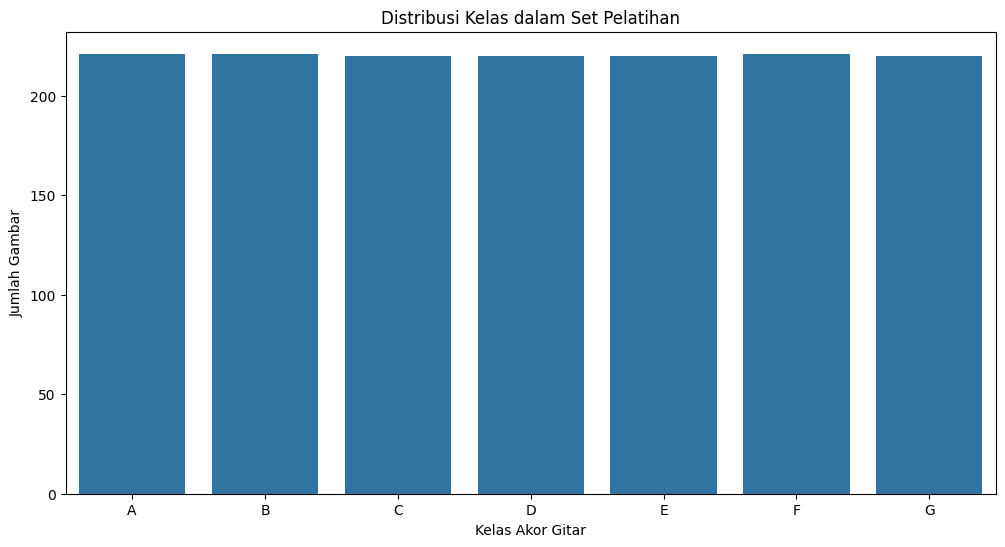

In [9]:
# Analyze Class Distribution
class_counts = np.bincount(y_train)
print("Jumlah gambar per kelas dalam set pelatihan:")
for i, count in enumerate(class_counts):
    print(f"Kelas {classes[i]}: {count} gambar")

# Visualize Class Distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=class_counts)
plt.title('Distribusi Kelas dalam Set Pelatihan')
plt.xlabel('Kelas Akor Gitar')
plt.ylabel('Jumlah Gambar')
plt.show()

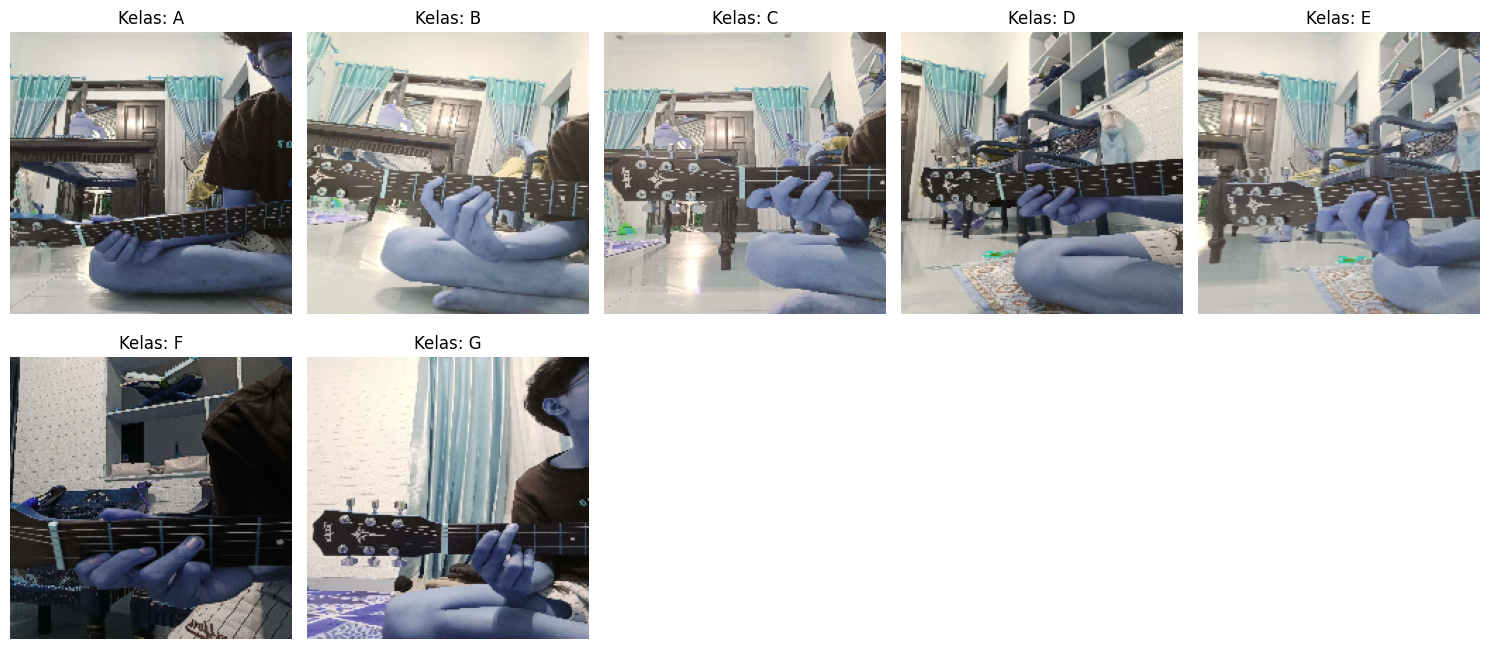

In [10]:
# Visualize Sample Images per Class
plt.figure(figsize=(15, 10))
for i in range(len(classes)):
    # Find the index of the first image for each class in the training set
    idx = np.where(y_train == i)[0][0]
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f"Kelas: {classes[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    # No augmentation for validation data, only ensure correct type if needed
)


In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

# 2️⃣ Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
total_params = model.count_params()
print(f"Total Parameters: {total_params}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,667,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,761,415 (33.42 MB)

 Trainable params: 8,761,415 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

Total Parameters: 8761415


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "guitar_chord_cnnmodel.keras",
    monitor="val_loss",    # atau "val_loss"
    mode="min",                # "max" untuk akurasi, "min" untuk loss
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, checkpoint]

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=batch_size),  # ← gunakan datagen.flow()
    epochs=epochs,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 378ms/step - accuracy: 0.3104 - loss: 2.0489 - val_accuracy: 0.8610 - val_loss: 0.4871
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.7476 - loss: 0.6754 - val_accuracy: 0.9215 - val_loss: 0.3774
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.8289 - loss: 0.5047 - val_accuracy: 0.9396 - val_loss: 0.1689
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 271ms/step - accuracy: 0.8911 - loss: 0.3041 - val_accuracy: 0.9728 - val_loss: 0.1294
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - accuracy: 0.9278 - loss: 0.2244 - val_accuracy: 0.9486 - val_loss: 0.1544
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - accuracy: 0.9393 - loss: 0.1803 - val_accuracy: 0.9486 - val_loss: 0.1070
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - accuracy: 0.9249 - loss: 0.2057 - val_accuracy: 0.9819 - val_loss: 0.0882
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - accuracy: 0.9677 - loss: 0.1273 - val_accu

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2354
Test Accuracy: 0.9909


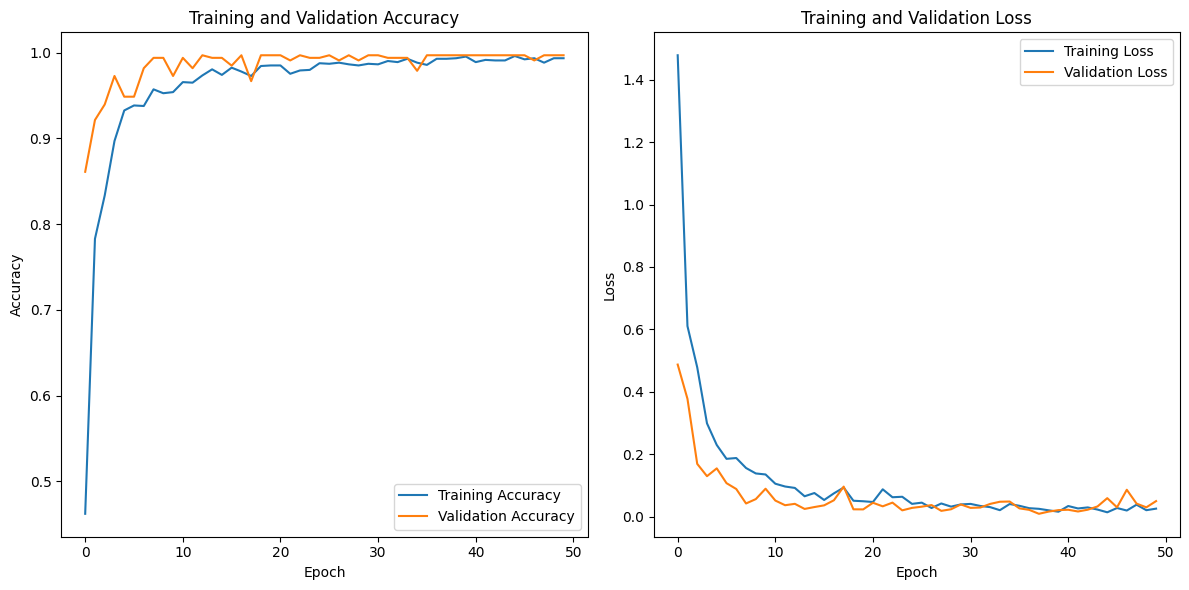

In [ ]:
# Visualize training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('guitar_chord_cnnbestoo_model.keras')
print("Model successfully saved as 'guitar_chord_cnn2_model.keras'")

Model successfully saved as 'guitar_chord_cnn2_model.keras'


In [ ]:
!zip -r "/content/drive/MyDrive/dataset_split.zip" "/content/dataset_split"


zip I/O error: No such file or directory
zip error: Could not create output file (/content/drive/MyDrive/dataset_split.zip)


In [ ]:
zip_path = "/content/dataset_split"
shutil.make_archive(zip_path, 'zip', base_dir)

print("📦 File zip dibuat:", zip_path + ".zip")


📦 File zip dibuat: /content/dataset_split.zip


In [ ]:
from google.colab import files
files.download(zip_path + ".zip")

print("\n✅ Dataset split berhasil dan siap diunduh!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Dataset split berhasil dan siap diunduh!


In [ ]:
# Load the specific image 'chordA.jpg'
image_path = '/content/chordAe.jpg'

# Read the image using OpenCV
img_orig = cv2.imread(image_path)

if img_orig is not None:
    # Resize the image to the required dimensions (IMG_WIDTH, IMG_HEIGHT)
    img_processed = cv2.resize(img_orig, (IMG_WIDTH, IMG_HEIGHT))
    # Normalize pixel values to [0, 1]
    img_processed = img_processed.astype('float32') / 255.0
    # Add a batch dimension (model expects a batch of images)
    img_for_prediction = np.expand_dims(img_processed, axis=0)

    # Make a prediction using the trained model
    pred_probs = model.predict(img_for_prediction)
    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(pred_probs)
    # Get the predicted class name
    predicted_class_name = classes[predicted_class_index]

    print(f"Predicted Chord: {predicted_class_name}")
    print(f"Prediction Probabilities: {pred_probs}")

    # Visualize the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # OpenCV reads BGR, Matplotlib expects RGB
    plt.title(f"Gambar Input: {predicted_class_name}")
    plt.axis('off')

    # Visualize the prediction probabilities
    plt.subplot(1, 2, 2)
    sns.barplot(x=classes, y=pred_probs[0])
    plt.title('Probabilitas Prediksi Kelas')
    plt.xlabel('Kelas Akor Gitar')
    plt.ylabel('Probabilitas')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print(f"Error: Could not load image from {image_path}")